# Submission Notebook

We have worked on optimising the charging and discharging of the battery.

## Exploratory Data Analysis

Let's look at the 'apx_da_hourly' data.

In [1]:
from Hack import load
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

In [2]:
epex = load.epex().load()

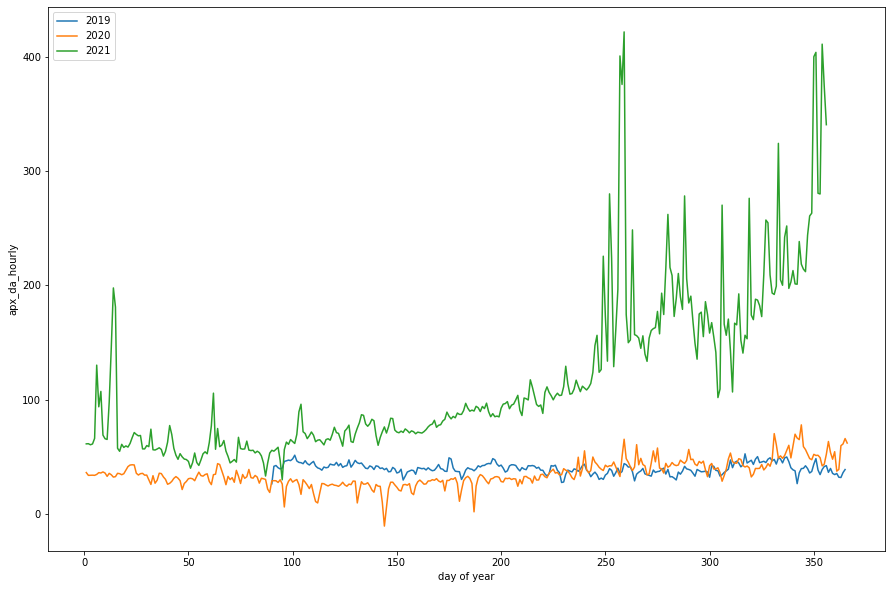

In [3]:
# Show seasonal trends
epex['doy'] = epex.index.day_of_year
epex['year'] = epex.index.year
fig, axs = plt.subplots(1,1, figsize=(15,10), sharex='col')
for i in [2019, 2020, 2021]:
    epex_temp = epex.loc[epex.year==i]
    epex_group = epex_temp.groupby(['doy']).mean()
    axs.plot(epex_group.index, epex_group['apx_da_hourly'], label=str(i))
    axs.set_ylabel('apx_da_hourly')
    axs.set_xlabel('day of year')
axs.legend()
fig.subplots_adjust(hspace=0.1)

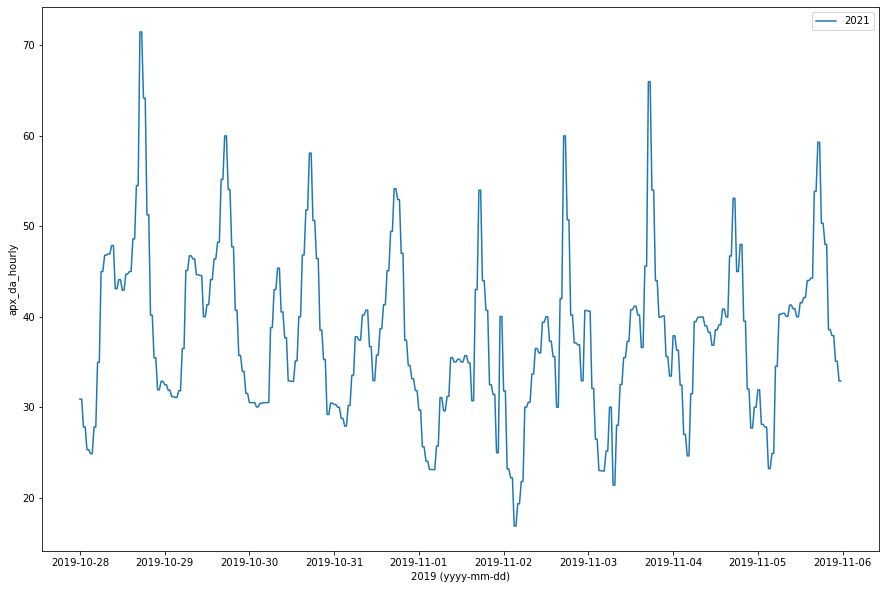

In [4]:
# Show daily variations (e.g. 2019)
doy1 = 300
doy2 = 310
fig, axs = plt.subplots(1,1, figsize=(15,10), sharex='col')
epex_temp = epex.loc[(epex.doy>doy1)&(epex.doy<doy2)&(epex.year==2019)]
axs.plot(epex_temp.index, epex_temp['apx_da_hourly'], label=str(i))
axs.set_ylabel('apx_da_hourly')
axs.set_xlabel('2019 (yyyy-mm-dd)')
axs.legend()
fig.subplots_adjust(hspace=0.1)

# Challenge

We decided to focus on the optimisation side of the project, feeling more confident with this than the forecasting

# Model

* The problem is how to train a program to allow a battery to decide at each point in time whether to charge or discharge, so that overall it tends to maximise the cumulatibe profit
* We settled on solving this using a reinforcement learning approach because the problem wasn't obviously a regression or classification issue, more learning a strategy for when to buy or sell
* Reinforcement learning is good for this because it allows an informed improvement to the policy as well as optimising the profit 

 Implementation

* We used the stable_baselines3 package, due to its good documentation
* We defined a custom Gym Environment class to define our game, which effectively sets out the rules for our algorithm
* We need to define an action_space and an observation_space for this environment. The action_space consisted of all the actions our agent (battery could do). This was buy energy (& charge the battery), sell energy (& discharge the battery) or hold. The observation_space is the all of the properties of the environment that can influence the actions the agent might take. 
* Our observation_space consisted of the current price of electricity, the current energy of the battery and some metric for whether it would be good or bad to sell energy
* This last feature was the most difficult feature to decide. This is probably the most crucial feature however because it is basically what determines our reward or punishment scheme for our battery. We wanted to punish our battery if it tries to buy energy when the price is high, or sell when the price is low. And vice versa. We did this by calculating at every 30 minute interval the revenue if the battery tried to buy or sell for the next 30 minutes, and compared this to the theoretical amount that could be made if the price was equal to the average price (our metric for what is high and what is low). Originally, we used the mean for the average but we found that this meant that spikes in the data were really problematic as they strongly offset the mean. Instead, we found the median a much more sensible measure. The figures expected_price_2019.png, expected_price_2020.png, expected_price_2021.png show this
* We trained the data on the first two years of data (2019 and 2020), and then tried to make predictions in 2021 based on this trained model

# Results

### (See the figure directory for our results)

1) We originally trained our data on a week's worth of data at the start of 2019. We then got predictions for the next week of data. Here the model is clearly working as expected. We evaluate the mean reward of our model and find that it's positive (our model is making a profit). And better than the random model.
2) We then train our dataset on a month's worth of data at the start of 2019 and then get predictions for the next month. The model still performs well and better than the random model. The model has good behaviours
3) Ultimately, we want to model data in 2021. So we treat 2019-2020 as a training dataset and then predict values for 2021. This is where our model fails to work effectively. We think this is because we don't have a good way to handle spikes in the data. Our model can't predict future spikes at all, so sometimes it sells when the price is yet to climb (which we don't penalise). 

In [6]:
from RL import helpers
from Hack import load
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

epex = load.epex().load()
price_array = epex['apx_da_hourly'].values

In [8]:
start_of_2020 = None
start_of_2021 = None

for idx, (i, row) in enumerate(epex.iterrows()):
    if i.year > 2019 and start_of_2020 is None:
        start_of_2020 = idx
    if i.year > 2020 and start_of_2021 is None:
        start_of_2021 = idx
        break
print(start_of_2020, start_of_2021)

13202 30770


In [4]:
loaded_model = PPO.load("Models/train_first_month.zip")

C:\Users\Ronan\Anaconda3\envs\ml\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Mean reward: 14887.107 +/- 0.0 	 Num episodes: 1


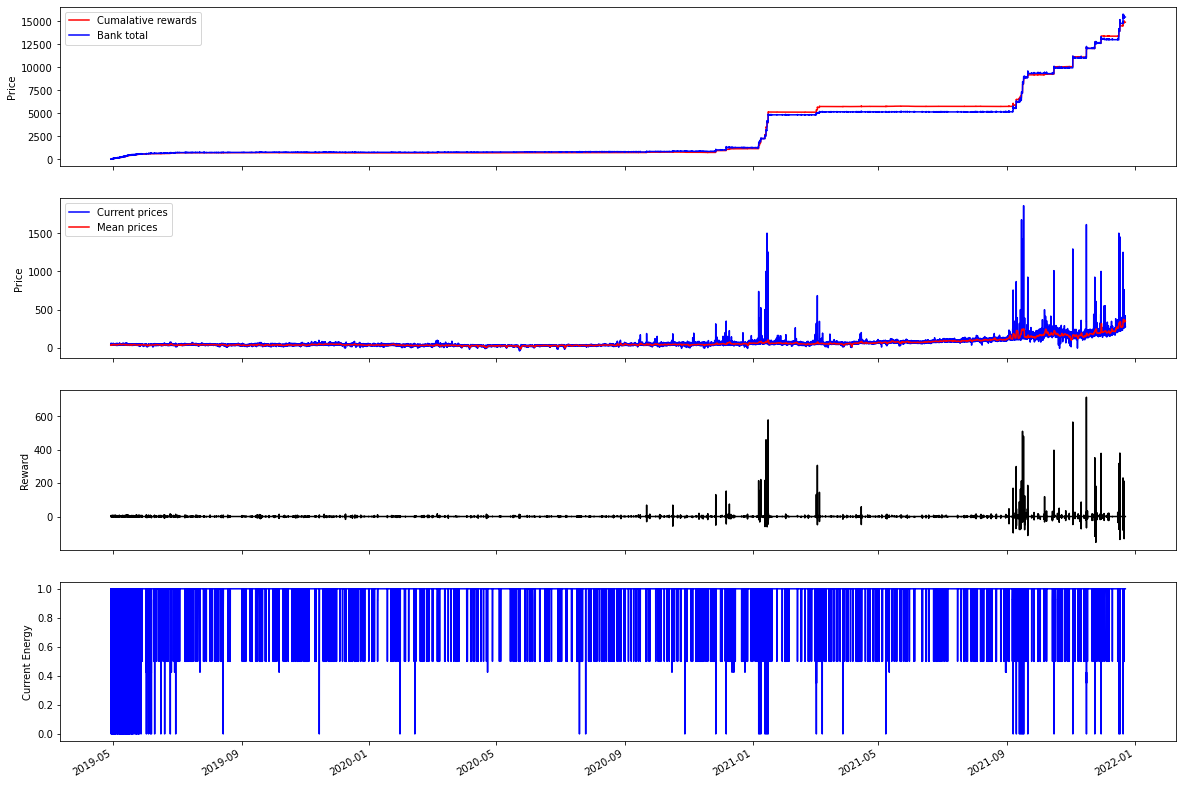

In [9]:
%matplotlib inline

period = 'all'
# period = 'sept'

if period == 'sept':
    # test on september
    test_start_idx = 42434 # end_idx # start_of_2020 # end_idx # start_of_2020 # 2*24*7
    test_end_idx =  test_start_idx + 4*7*24*2 # -1 # start_of_2021 # 2*end_idx # start_of_2021 # 30770 + 2*24*7
elif period == 'all':
    test_start_idx = 4*7*24*2
    test_end_idx =  -1
elif period == '2020':
    test_start_idx = start_of_2020
    test_end_idx =  start_of_2021
elif period == '2021':
    test_start_idx = start_of_2021
    test_end_idx =  -1

test_price_array = price_array[test_start_idx:test_end_idx]

new_env =  DummyVecEnv([lambda: helpers.energy_price_env(test_price_array)])
mean_reward_after_train = helpers.evaluate(loaded_model, new_env=new_env, num_episodes=1, index=epex.index[test_start_idx:test_end_idx])

# Conclusions

* The optimal strategy is to sit on a full charge and to sell when there is a spike in the energy price and then to buy again as soon as the price has decreased again

# Further improvements

Given further time, there are some improvements we would love to make to this optimiser

* We would to tune the hyperparameters using a Bayesian or other method for our particular dataset. Bayesian would be a good tool for this because its an efficient minimisation of an expensive multidimensional function. Due to time constraints, we were forced to just use defaults
* We would like to come up with a better scheme of rewards and punishments for our function, which could deal better with the large spikes in the dataset that seem to cause us issues
* The algorithm often seems to get stuck with full charge and discharging rarely. We would like to punish this behaviour.
* We would to like to incorporate a forecasting model so that our agent can estimate that if it was to hold for a certain amount of time, it could make a bigger profit in the future. As it is, this is something not easily implemented in our current model
* We would like to experiment with different algorithms and policies